In [4]:
import os
import sys
import pickle
from tqdm import tqdm
import itertools
import dateparser
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates

# Add repo
git_dir = os.path.abspath('../')

# Define data path
data_path = os.path.join(git_dir, 'data', 'pm-transcripts')\

# Define data output path
data_output_path = os.path.join(git_dir, 'data', 'pm-transcripts-processed')

# Pickle path
df_pickle_path = os.path.join(data_output_path, 'aggregated-spellfixed-typed-emotions.pkl')



In [2]:
coarse_emotions = ['positive', 'negative', 'ambiguous', 'neutral']

positive_emotions = ['admiration', 
                     'amusement',
                     'approval',
                     'caring',
                     'desire',
                     'excitement',
                     'gratitude',
                     'joy',
                     'love',
                     'optimism',
                     'pride',
                     'relief']

negative_emotions = ['anger',
                     'annoyance',
                     'disappointment',
                     'disapproval',
                     'disgust',
                     'embarrassment',
                     'fear',
                     'grief',
                     'nervousness',
                     'remorse',
                     'sadness']

ambiguous_emotions = ['confusion',
                      'curiosity',
                      'realization',
                      'surprise']

neutral_emotions = ['neutral']

all_emotions = list(itertools.chain.from_iterable([positive_emotions, negative_emotions, ambiguous_emotions, neutral_emotions]))

emotion_mapper = {}
for emotion in all_emotions:
    if emotion in positive_emotions:
        emotion_mapper[emotion] = coarse_emotions[0]#'coarspositive'
        
    elif emotion in negative_emotions:
        emotion_mapper[emotion] = coarse_emotions[1]#'negative'
        
    elif emotion in ambiguous_emotions:
        emotion_mapper[emotion] = coarse_emotions[2]#'ambiguous'
        
    elif emotion in neutral_emotions:
        emotion_mapper[emotion] = coarse_emotions[3]#'neutral'
    
    else:
        raise ValueError(emotion)

In [31]:
df = pd.read_pickle(df_pickle_path)

Let's do all of the processing on the whole data frame

In [32]:
def count_emotions(sentence_emotion_list):
    '''
    Count the number of times each emotion is expressed in a sentence
    Count the total number of sentence
    Count the total number of emotions expressed
    '''
    
    emotion_counter_fine = {k: 0 for k in all_emotions}
    emotion_counter_coarse = {k: 0 for k in coarse_emotions}
    emotion_counter_nonneutral = 0
    emotion_counter_all = 0
    
    for sentence in sentence_emotion_list:
        for i, label in enumerate(sentence['labels']):
            emotion_counter_fine[label] += 1
            emotion_counter_coarse[emotion_mapper[label]] += 1
            emotion_counter_all += 1
            
            if label not in neutral_emotions:
                emotion_counter_nonneutral += 1
            
            
    return emotion_counter_fine, emotion_counter_coarse, emotion_counter_all, emotion_counter_nonneutral

In [33]:
# Get stats for emotion counts across sentences in each document
tmp = df['sentences_emotions'].apply(lambda x: count_emotions(x))

In [34]:
tmp2 = list(zip(*list(tmp)))
# df['emotions_fine_count'] = tmp2[0]
# df['emotions_coarse_count'] = tmp2[1]
df['emotions_count_all'] = tmp2[2]
df['emotions_count_nonneutral'] = tmp2[3]
df[['emotions_count_fine_'+x for x in all_emotions]] = pd.DataFrame(tmp2[0], index=df.index)
df[['emotions_count_coarse_'+x for x in coarse_emotions]] = pd.DataFrame(tmp2[1], index=df.index)
df['datetime'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y'))

In [116]:
df.columns

Index(['Unnamed: 0', 'pm', 'date', 'type', 'content', 'sentences',
       'sentences_emotions', 'emotions_count_all', 'emotions_count_nonneutral',
       'emotions_count_fine_admiration', 'emotions_count_fine_amusement',
       'emotions_count_fine_approval', 'emotions_count_fine_caring',
       'emotions_count_fine_desire', 'emotions_count_fine_excitement',
       'emotions_count_fine_gratitude', 'emotions_count_fine_joy',
       'emotions_count_fine_love', 'emotions_count_fine_optimism',
       'emotions_count_fine_pride', 'emotions_count_fine_relief',
       'emotions_count_fine_anger', 'emotions_count_fine_annoyance',
       'emotions_count_fine_disappointment', 'emotions_count_fine_disapproval',
       'emotions_count_fine_disgust', 'emotions_count_fine_embarrassment',
       'emotions_count_fine_fear', 'emotions_count_fine_grief',
       'emotions_count_fine_nervousness', 'emotions_count_fine_remorse',
       'emotions_count_fine_sadness', 'emotions_count_fine_confusion',
       

In [ ]:
prefix = 'emotions_count_coarse_'
emotion_list = coarse_emotions[0:-1]
df_tmp = df.copy().sort_values(by='date').set_index('date')
df2 = df_tmp[[prefix+x for x in emotion_list]].copy()
for column in df2.columns:
    df2[column] = df2[column].fillna(0)/df['emotions_count_nonneutral'].fillna(0)
        

In [103]:
def get_coarse_proportional_emotion_df(df_in):
    # We exclude 'neutral'
    prefix = 'emotions_count_coarse_'
    emotion_list = coarse_emotions[0:-1]
    df_tmp = df_in.copy().sort_values(by='datetime').set_index('datetime')
    df = df_tmp[[prefix+x for x in emotion_list]].copy()
    for column in df.columns:
        x = np.array(df[column])
        y = np.array(df_in['emotions_count_nonneutral'])
        df[column] = np.divide(x, y)
    df = df.fillna(0)
        
    df.columns = [column+'_normed' for column in df.columns]
    df = df.fillna(0)
        
    return df

def get_coarse_proportional_emotion_df_with_neutral(df_in):
    # We exclude 'neutral'
    prefix = 'emotions_count_coarse_'
    emotion_list = coarse_emotions
    df_tmp = df_in.copy().sort_values(by='datetime').set_index('datetime')
    df = df_tmp[[prefix+x for x in emotion_list]].copy()
    
    for column in df.columns:
        x = np.array(df[column])
        y = np.array(df_in['emotions_count_all'])
        df[column] = np.divide(x, y)
    df = df.fillna(0)

    df.columns = [column+'_normed' for column in df.columns]
    df = df.fillna(0)
    
        
    return df
    

In [172]:
def plot_coarse_emotion_proportions(df_coarse, window='120d', title='PM Speech Sentiment Proportion'):
    plot_colors = sns.color_palette("hls", 8)
    plot_colors = [plot_colors[2], plot_colors[0], plot_colors[1], [0.5, 0.5, 0.5]]
    
    legend_labels = ['Positive', 'Negative', 'Ambiguous', 'Neutral']
    
    SMALL_SIZE = 15
    MEDIUM_SIZE = 18
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE) 
    
    
    
    # Take rolling average over window
    df = df_coarse.rolling(window).mean().copy()
    
    # Renormalise
    df_norm = df.sum(axis=1)
    for column in df.columns:
        df[column] = df[column]/df_norm
    df = df.fillna(0)
    
    line_list = []
    for i, column in enumerate(df_coarse.columns):
        if i==0:
            line_list.append(df_coarse[column])
        else:
            line_list.append(df_coarse[column]+line_list[-1])
            
    #plt.plot(df.cumsum(axis=1))
    # Take cumulative sum
    df_cumsum = df.cumsum(axis=1) # column names are unchanged
    
    
    # Plot filled regions
    fig=plt.figure(figsize=(16,6), dpi= 100, facecolor='w', edgecolor='k')
    
    for i, col in enumerate(df_cumsum.columns):
        if i==0:
            plt.fill_between(df_cumsum.index, 0*df_cumsum[col], df_cumsum[col], color=plot_colors[i], alpha=0.5, label=legend_labels[i])
        else:
            plt.fill_between(df_cumsum.index, df_cumsum[prev_col], df_cumsum[col], color=plot_colors[i], alpha=0.5, label=legend_labels[i])
        prev_col = col
        
    for i, col in enumerate(df_cumsum.columns):
        plt.plot(df_cumsum.index, df_cumsum[col], color=plot_colors[i], lw=2)
        
    ax= plt.gca()
    monthyearFmt = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(monthyearFmt)
    ax.xaxis.set_major_locator(mdates.MonthLocator([1,7]))
    _ = plt.xticks(rotation=45)
    #ax.set_xticks(ax.get_xticks()[::1])
    
    plt.grid()
    plt.axis('tight')
    plt.autoscale(enable=True, axis='both', tight=True)
    plt.legend()
    plt.xlabel('Date',  fontweight='bold')
    plt.ylabel('Proportion',  fontweight='bold')
    plt.title(title,  fontweight='bold' )

In [286]:
# Averaging Window length
win_len = '30d'

/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


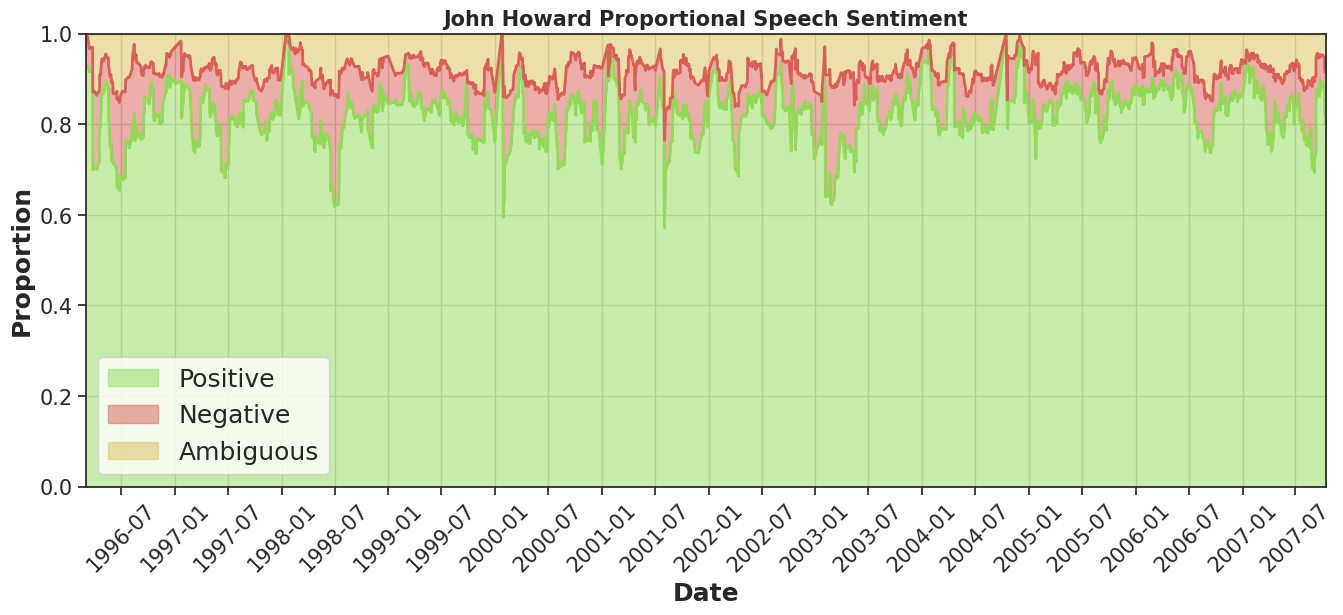

In [198]:
df_coarse = get_coarse_proportional_emotion_df(df[df['pm']=='Howard, John'])
plot_coarse_emotion_proportions(df_coarse, window=win_len, title='John Howard Proportional Speech Sentiment')

/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


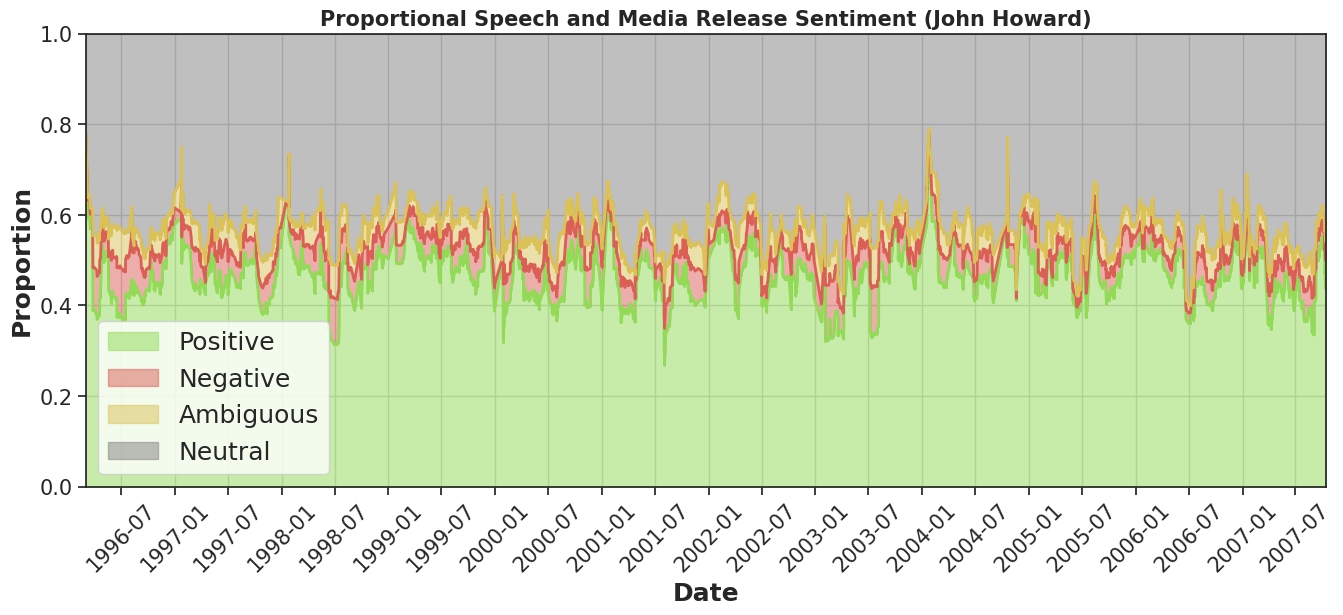

In [199]:
df_coarse = get_coarse_proportional_emotion_df_with_neutral(df[df['pm']=='Howard, John'])
plot_coarse_emotion_proportions(df_coarse, window=win_len, title='Proportional Speech and Media Release Sentiment (John Howard)')

### Repeat for Gillard, Julia

/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


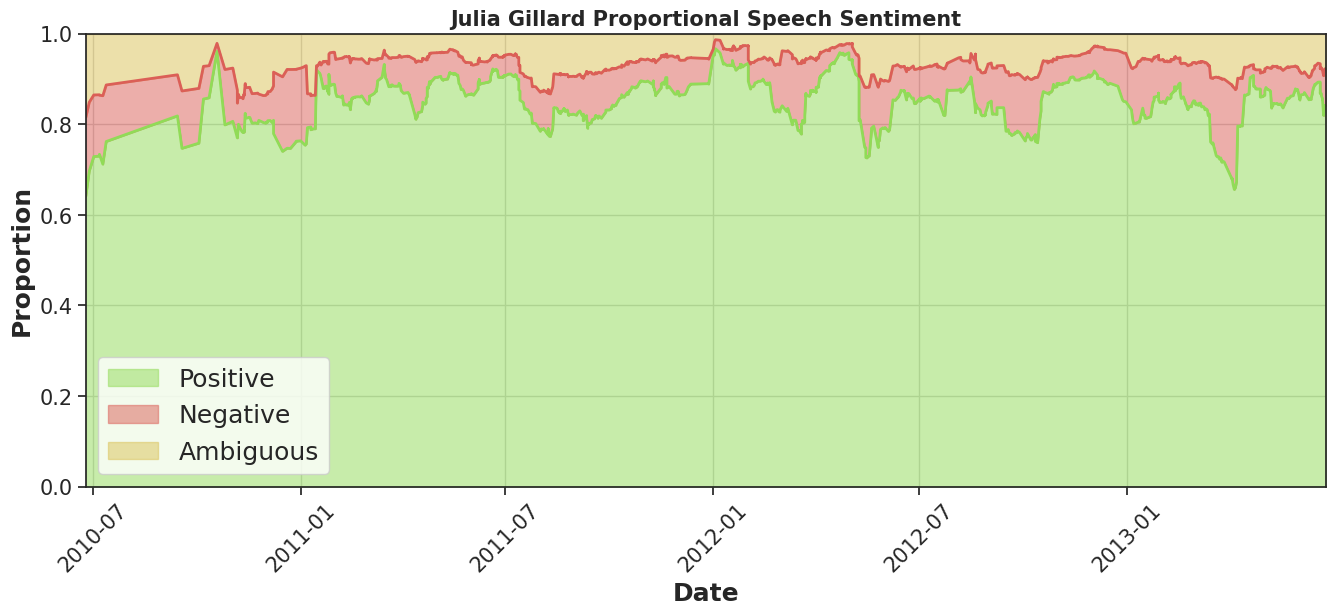

In [202]:
df_coarse = get_coarse_proportional_emotion_df(df[df['pm']=='Gillard, Julia'])
plot_coarse_emotion_proportions(df_coarse, window=win_len, title='Julia Gillard Proportional Speech Sentiment')

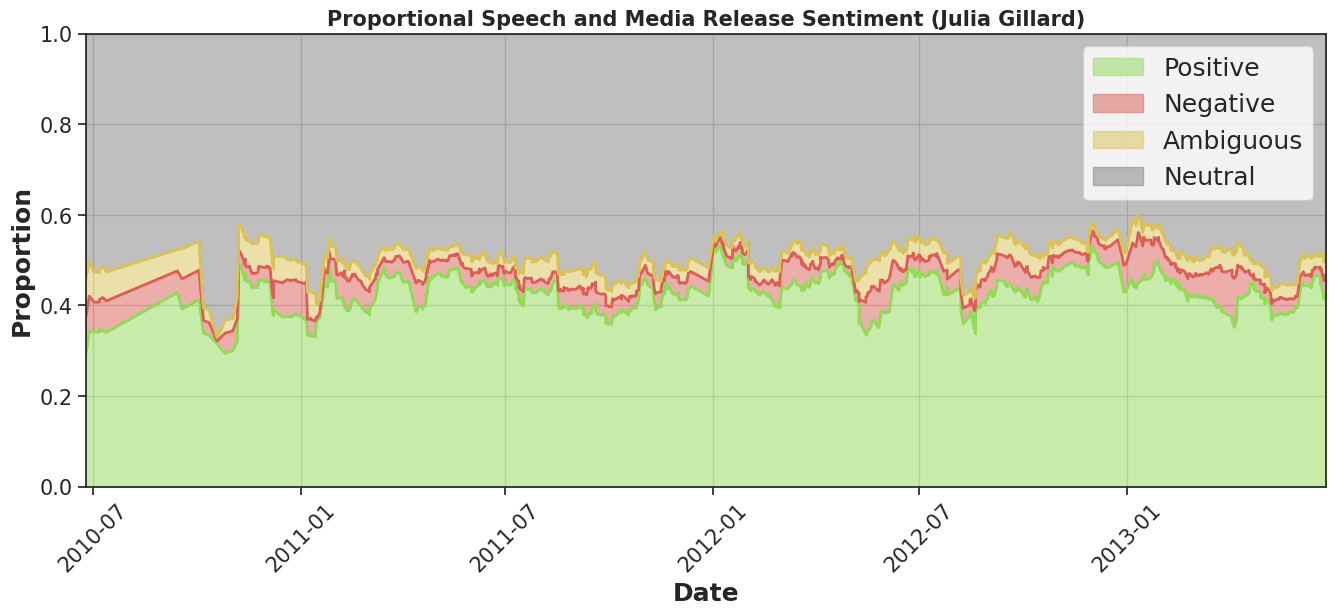

In [203]:
df_coarse = get_coarse_proportional_emotion_df_with_neutral(df[df['pm']=='Gillard, Julia'])
plot_coarse_emotion_proportions(df_coarse, window=win_len, title='Proportional Speech and Media Release Sentiment (Julia Gillard)')

### Repeat for Tony Abbott

/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


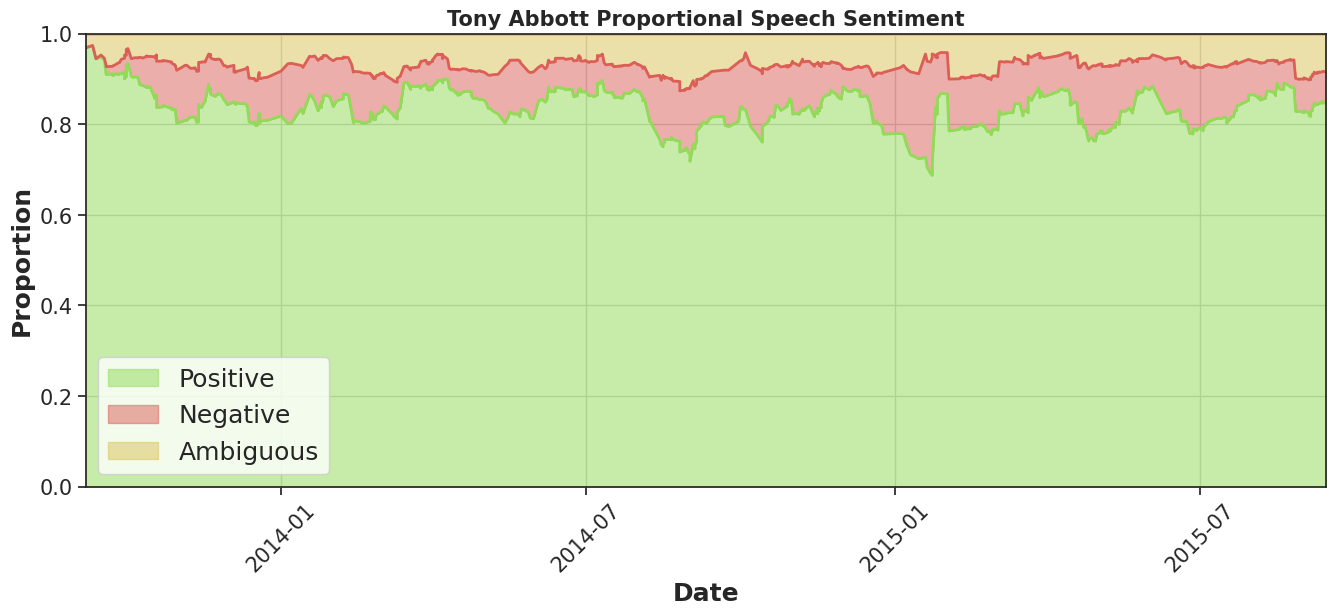

In [205]:
df_coarse = get_coarse_proportional_emotion_df(df[df['pm']=='Abbott, Tony'])
plot_coarse_emotion_proportions(df_coarse, window=win_len, title='Tony Abbott Proportional Speech Sentiment')

/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


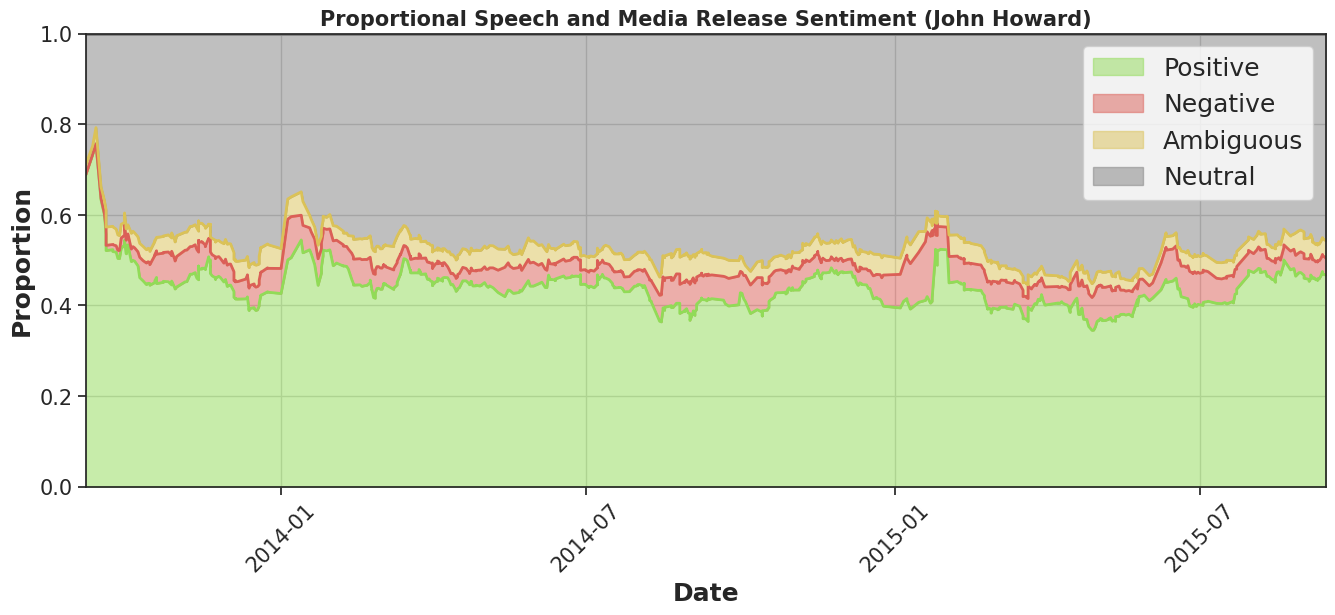

In [206]:
df_coarse = get_coarse_proportional_emotion_df_with_neutral(df[df['pm']=='Abbott, Tony'])
plot_coarse_emotion_proportions(df_coarse, window=win_len, title='Proportional Speech and Media Release Sentiment (John Howard)')

##  Let's look at how the distribution of use of emotion varies between politicians
Again, let's look at proportionate representation per document.

In [250]:
def construct_emotion_fine_boxplot_df(df_in_0, prime_ministers, use_norm=True):
    emotions = all_emotions
    emotions_cols = ['emotions_count_fine_'+x for x in emotions]
    quant_label = 'Count'
    
    df_in = df_in_0.copy()
    if use_norm:
        quant_label = 'Proportion'
        emotions = emotions[0:-1]
        emotions_cols = ['emotions_count_fine_'+x for x in emotions]
        for col in emotions_cols:
            x = np.array(df_in[col])
            y = np.array(df_in['emotions_count_nonneutral'])
            df_in[col] = np.divide(x, y)
        df_in = df_in.fillna(0)
            
    df_tmp = df_in[df_in['pm'].isin( prime_ministers)][['pm', emotions_cols[0]]]
    df_tmp.columns = ['Prime Minister', quant_label]
    df_tmp['Emotion'] = emotions[0]
    df = df_tmp.copy()
    for i in range(1, len(emotions_cols)):
        df_tmp = df_in[df_in['pm'].isin( prime_ministers)][['pm', emotions_cols[i]]]
        df_tmp.columns = ['Prime Minister', quant_label]
        df_tmp['Emotion'] = emotions[i]
        
        df = df.append(df_tmp)
        
    return df.copy(), quant_label

In [268]:
df_bp, quant_label = construct_emotion_fine_boxplot_df(df, ['Howard, John', 'Gillard, Julia'])

/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [269]:
sns.set(style="ticks", palette="pastel")

/home/mahasen/anaconda3/envs/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


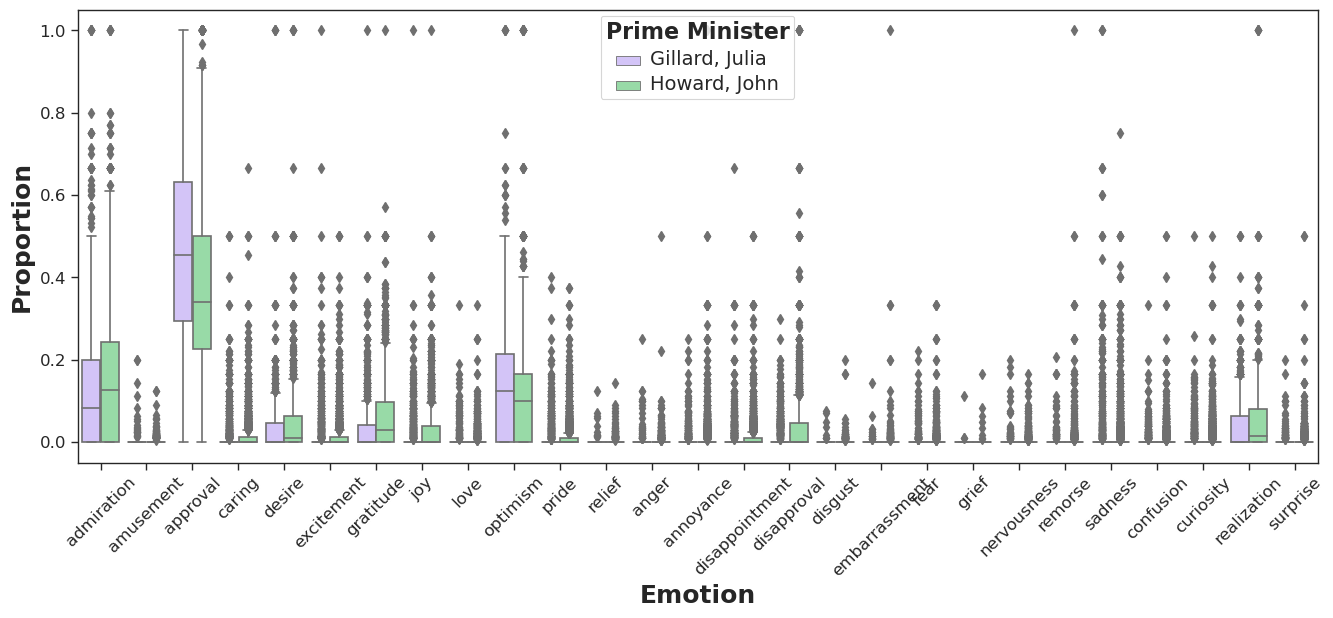

In [285]:
#sns.set_context("paper")
df_bp, quant_label = construct_emotion_fine_boxplot_df(df, ['Howard, John', 'Gillard, Julia'])
fig, ax = plt.subplots(figsize=(16,6), dpi= 100, facecolor='w', edgecolor='k')
chart = sns.boxplot(x="Emotion", y=quant_label,
            hue="Prime Minister", palette=["m", "g"],
            data=df_bp, ax=ax)
#sns.despine(offset=10, trim=True)
#plt.gca().set_xticklabels(ax.get_xticklabels(),rotation=30)
chart.set_xlabel("Emotion", fontweight='bold', fontsize=18)
chart.set_ylabel("Proportion", fontweight='bold', fontsize=18)
chart.tick_params(labelsize=12)

plt.setp(ax.get_legend().get_texts(), fontsize=14)  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=16, fontweight='bold')  # for legend title

plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()



Same plot, but without normalising by emotions per document

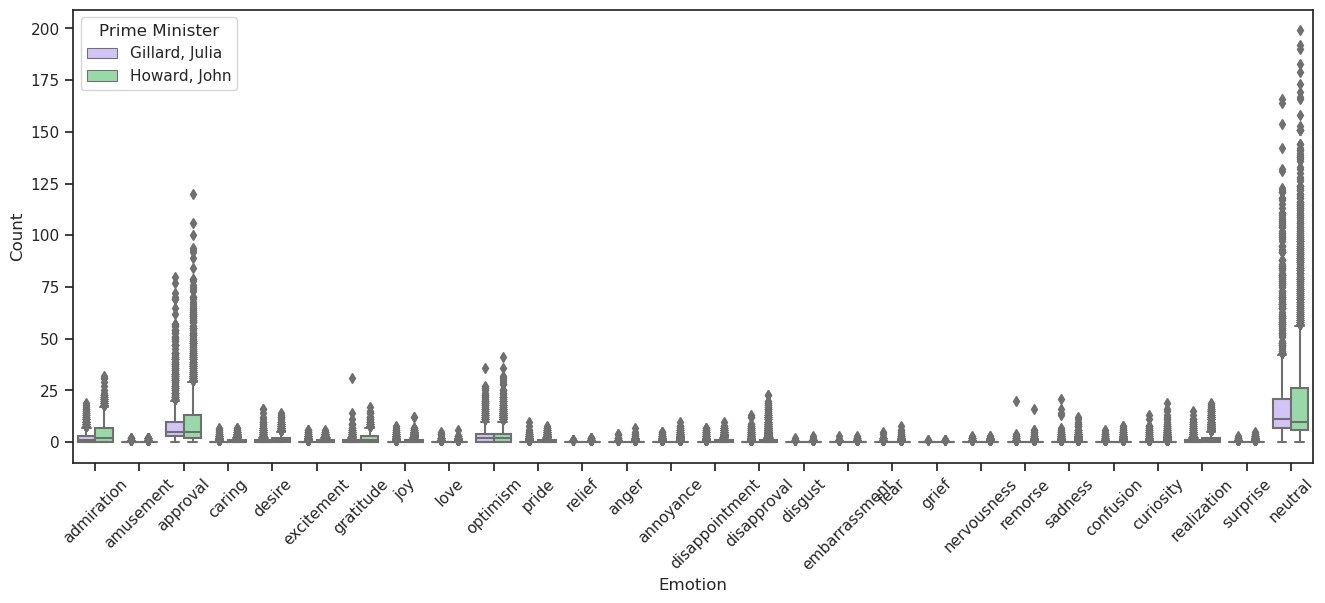

In [272]:
df_bp, quant_label = construct_emotion_fine_boxplot_df(df, ['Howard, John', 'Gillard, Julia'], use_norm=False)
fig, ax = plt.subplots(figsize=(16,6), dpi= 100, facecolor='w', edgecolor='k')
chart = sns.boxplot(x="Emotion", y=quant_label,
            hue="Prime Minister", palette=["m", "g"],
            data=df_bp, ax=ax)
#sns.despine(offset=10, trim=True)
#plt.gca().set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()
